<a href="https://colab.research.google.com/github/akshayonly/ML-CS-classify-genetic-mutation/blob/main/Classifying_Genetic_Mutation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Genetic mutation from high-dimensional clinical features

**OBJECTIVE**

The goal of this case study is to classify the genetic mutation classes by reducing the dimension through feature selection and how it impacts on ML models performance metrics.

CONTENT



1. Packages
2. Downloading data
3. Data preprocessing
4. Primary data analysis
5. Data featurization
   1. Categorical feature with One-hot encoding
   2. Text feature with TF-IDF 
6. Secondary data analysis
7. Machine learning models
   1. Ensemble-Based
      1. Random Forest
      2. Feature selection with RF
      3. Random Forest with selected features
   2. Neighborhood-Based
      1. k-NN
      2. k-NN with selected features
   3. Linear Models
      1. SVM 
      2. SVM with selected features
      3. Logistic Regression
      4. Logistic Regression with selected features
   4. Bayesian Model
      1. Naive-Bayes
      2. Naive-Bayes with selected features
   5. Conclusion

<a name="cell-id1"></a>
# Packages

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns

import re
from tqdm import tqdm
from datetime import datetime

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import normalize, StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, f1_score, balanced_accuracy_score

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")

nltk.download('stopwords')
nltk.download('punkt')

palette = sns.color_palette("Paired", 9)
plt.style.use('seaborn-notebook')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
start=datetime.now()

# Downloading data

In [3]:
# Train Texts
! wget --header 'Host: storage.googleapis.com' --user-agent 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:87.0) Gecko/20100101 Firefox/87.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://www.kaggle.com/' --header 'DNT: 1' --header 'Upgrade-Insecure-Requests: 1' --header 'Sec-GPC: 1' 'https://storage.googleapis.com/kagglesdsdata/competitions/6841/44307/training_text.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1617008860&Signature=QfJ5ZdxHSxKoXPlMr8jzZps8EhiRPj96kCzii0FAySYZ0Myn6iSyuSrlWe2ybDynfDRbakpZESoF88XRS6zV9PsPEXNNCVgM1IUGDjj%2FtqDa1NTTcCjwLEhiKFTT7pAFR6O%2BAMaQ0Cepi5ZPYVcUbI1cJcEiuHe0Nk0x%2FCkdTtZRgMCYONMycPdHTVj0dlOtniqxtx0N7yORbregcmI3kGgG%2BVa6n9EMJSZX5vbIC5AW1VodpzxsCqNgnjGCW51gnb0NmipZwxbnCJ%2FZb3fQRCuIiNtX7rOL%2BYGfnfnWZQRC21G5Xx4%2BX%2B%2FSPGFrg3FpdcmJHGVY8S%2FJKS8PQv3%2FCA%3D%3D&response-content-disposition=attachment%3B+filename%3Dtraining_text.zip' --output-document 'training_text.zip' && unzip training_text.zip

# Train Variants
! wget --header 'Host: storage.googleapis.com' --user-agent 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:87.0) Gecko/20100101 Firefox/87.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://www.kaggle.com/' --header 'DNT: 1' --header 'Upgrade-Insecure-Requests: 1' --header 'Sec-GPC: 1' 'https://storage.googleapis.com/kagglesdsdata/competitions/6841/44307/training_variants.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1617008828&Signature=daXpYlinA3JfM6dRDJO81AddsFlJ07GrZA%2FGaJHfHrhDEx69HUbj24gbH2ahVgwwjZtZ6FICDEefb8IoJXXceQEZEMy53%2Ff9QgMhI7PBgPFtQ3KgdzZ3%2BipqvntyPQlsa92qCBBwC91iG65TMB%2B4AjfhqydDUEtjNXiySnndKWwt04FZqTtHRf3LBvhwpf5mdi9U3Duk%2FI%2BnxDyoRwo1b2ffV3CJbNWDJSuXnN%2Fu8BmiCqndjVN6fi772VeXHn9R3vsgYEs4g%2FhTUFzSn%2FaW0%2FPrtKVhx%2Fd3QuqhQUh3%2BVNoI9qvFBB%2BlyyfyYUNBMsxrd0Oi6zkPmM8R2q6TeSTzg%3D%3D&response-content-disposition=attachment%3B+filename%3Dtraining_variants.zip' --output-document 'training_variants.zip' && unzip training_variants.zip

--2021-03-29 07:01:22--  https://storage.googleapis.com/kagglesdsdata/competitions/6841/44307/training_text.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1617008860&Signature=QfJ5ZdxHSxKoXPlMr8jzZps8EhiRPj96kCzii0FAySYZ0Myn6iSyuSrlWe2ybDynfDRbakpZESoF88XRS6zV9PsPEXNNCVgM1IUGDjj%2FtqDa1NTTcCjwLEhiKFTT7pAFR6O%2BAMaQ0Cepi5ZPYVcUbI1cJcEiuHe0Nk0x%2FCkdTtZRgMCYONMycPdHTVj0dlOtniqxtx0N7yORbregcmI3kGgG%2BVa6n9EMJSZX5vbIC5AW1VodpzxsCqNgnjGCW51gnb0NmipZwxbnCJ%2FZb3fQRCuIiNtX7rOL%2BYGfnfnWZQRC21G5Xx4%2BX%2B%2FSPGFrg3FpdcmJHGVY8S%2FJKS8PQv3%2FCA%3D%3D&response-content-disposition=attachment%3B+filename%3Dtraining_text.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.128.128, 142.251.6.128, 74.125.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63917183 (61M) [application/zip]
Saving to: ‘training_text.zip’

training_text.zip   100%

In [4]:
!ls -I *.zip

training_variants.zip


<a name="cell-id3"></a>
# Data Preprocessing

In [5]:
variants_data = pd.read_csv('/content/training_variants', index_col=False)
variants_data.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [6]:
texts_data = pd.read_csv('/content/training_text', 
                         sep="\|\|", 
                         engine="python", 
                         names=["ID","TEXT"], 
                         skiprows=1)

texts_data.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


## Merging variants and texts dataframes

In [7]:
data = pd.merge(texts_data, variants_data, on='ID', how='left')

data.head()

,ID,TEXT,Gene,Variation,Class
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,FAM58A,Truncating Mutations,1
1,1,Abstract Background Non-small cell lung canc...,CBL,W802*,2
2,2,Abstract Background Non-small cell lung canc...,CBL,Q249E,2
3,3,Recent evidence has demonstrated that acquired...,CBL,N454D,3
4,4,Oncogenic mutations in the monomeric Casitas B...,CBL,L399V,4


## Highlevel overview

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   TEXT       3316 non-null   object
 2   Gene       3321 non-null   object
 3   Variation  3321 non-null   object
 4   Class      3321 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 155.7+ KB


1. There are 3321 entries in the dataframe.
2. Leaving ``Class`` column which is numerical representation of genetic mutation classes, rest are object datatype i.e. categorical and text.
3. The ``TEXT`` column have 05 entries lesser than the total 3321, we'd look at them later.

In [9]:
data['Class'].describe()

count    3321.000000
mean        4.365854
std         2.309781
min         1.000000
25%         2.000000
50%         4.000000
75%         7.000000
max         9.000000
Name: Class, dtype: float64

## Preprocessing

### NaN values

In [10]:
data[data.isnull().any(axis=1)]

,ID,TEXT,Gene,Variation,Class
1109,1109,NaN,FANCA,S1088F,1
1277,1277,NaN,ARID5B,Truncating Mutations,1
1407,1407,NaN,FGFR3,K508M,6
1639,1639,NaN,FLT1,Amplification,6
2755,2755,NaN,BRAF,G596C,7


- There are 05 rows in the data in the ``'TEXT'`` column which are NaN
- We'd  remove them, as these are text base and we cannot replace them with other values.

In [11]:
data.dropna(subset = ["TEXT"], inplace=True)

### Standard NLP preprocessing
- Removing stop words
- Removing puntuations

In [12]:
stop_words = set(stopwords.words('english'))

def text_processing(text):
  """Processing the sentence (single entry)."""

  text = re.sub('\s+',' ', text)
  text = re.sub('[^a-zA-Z0-9\n]', ' ', text)
  text = text.lower()

  tokens = [token for token in word_tokenize(text) if token not in punctuation and token not in stop_words]

  return ' '.join(tokens)

In [13]:
for index, text in tqdm(data.TEXT.iteritems()):
  data["TEXT"][index] = text_processing(text)

3316it [02:35, 21.34it/s]


In [14]:
data.Gene = data.Gene.str.replace('\s+', '_')
data.Variation = data.Variation.str.replace('\s+', '_')

In [15]:
data.head(2)

,ID,TEXT,Gene,Variation,Class
0,0,cyclin dependent kinases cdks regulate variety...,FAM58A,Truncating_Mutations,1
1,1,abstract background non small cell lung cancer...,CBL,W802*,2


In [16]:
# Copying newly created dataframe into csv
# data.to_csv('CGM-processed.csv', index=False)

In [17]:
# Copying to google drive
# !cp -r /content/CGM-processed.csv /content/drive/MyDrive/Data/CGV-Data

<a name="cell-id4"></a>
# Primary data analysis

## Distribution of ``Class``

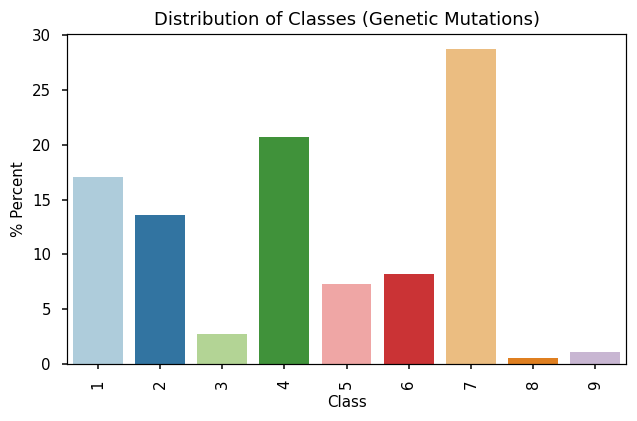

In [18]:
plt.figure(figsize=(6,4), dpi=108)
sns.barplot(x="Class", y="Class", data=data, palette=palette,
            estimator=lambda x: len(x) / len(data) * 100)
plt.ylabel('% Percent', fontsize=10)
plt.xlabel('Class', fontsize=10)
plt.xticks(rotation='vertical')
plt.title("Distribution of Classes (Genetic Mutations)", fontsize=12)
plt.tight_layout()
plt.show()

**Obsevation**
1. The class distribution is highly imbalanced. 
2. Most frequent genetic mutation classes are 7 (appx. 29%), followed by class 4 (appx. 21%).
3. Lowest occurancing classes are 8 and 9.
4. Due to presense of imbalance among classes, this can affect the predictive capabilities of the model.

<a name="cell-id5"></a>
# Data featurization

In [19]:
y = np.array(data['Class'].values)

In [20]:
X = data[data.columns[1:4]]

In [21]:
# Splitting the data into train and test
x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    stratify=y)

In [22]:
x_train.shape

(2321, 3)

In [23]:
x_test.shape

(995, 3)

## Categorical

In [24]:
# Create LabelBinzarizer object
one_hot = CountVectorizer()

# One-hot encode data
one_hot.fit(x_train['Gene'])

ohe_tr_gene = one_hot.transform(x_train['Gene'])
ohe_ts_gene = one_hot.transform(x_test['Gene'])

In [25]:
print(f"OneHotEncoded Gene: {ohe_tr_gene.shape}")
print(f"OneHotEncoded Gene: {ohe_ts_gene.shape}")

OneHotEncoded Gene: (2321, 242)
OneHotEncoded Gene: (995, 242)


In [26]:
# Create LabelBinzarizer object
one_hot = CountVectorizer()

# One-hot encode data
one_hot.fit(x_train['Variation'])

ohe_tr_var = one_hot.transform(x_train['Variation'])
ohe_ts_var = one_hot.transform(x_test['Variation'])

In [27]:
print(f"OneHotEncoded Variation (Train): {ohe_tr_var.shape}")
print(f"OneHotEncoded Variation (Test): {ohe_ts_var.shape}")

OneHotEncoded Variation (Train): (2321, 2117)
OneHotEncoded Variation (Test): (995, 2117)


## Text

### TF-IDF 

In [28]:
vec_start = datetime.now()

tfidf = TfidfVectorizer(ngram_range=(2, 4), 
                        max_features=3000).fit(x_train['TEXT'])

tfidf_tr_text = tfidf.transform(x_train['TEXT'])
tfidf_ts_text = tfidf.transform(x_test['TEXT'])

vec_end = datetime.now()
print(f"Took: {vec_end-vec_start}")

Took: 0:03:26.429814


In [29]:
tfidf_ts_text.shape

(995, 3000)

In [30]:
tfidf_tr_text.shape

(2321, 3000)

In [31]:
%xdel tfidf

## Concatenation

In [32]:
train = np.hstack((tfidf_tr_text.toarray(), 
                   ohe_tr_var.toarray(), 
                   ohe_tr_gene.toarray()))

test = np.hstack((tfidf_ts_text.toarray(), 
                  ohe_ts_var.toarray(), 
                  ohe_ts_gene.toarray()))

In [33]:
print(f"Train X: {train.shape}\ty: {y_train.shape}")
print(f"Test X: {test.shape}\ty: {y_test.shape}")

Train X: (2321, 5359)	y: (2321,)
Test X: (995, 5359)	y: (995,)


<a name="cell-id6"></a>
# Secondary data analysis

In [34]:
# Reducing dimension and projecting it onto 2D with t-SNE
train_tsne = TSNE(n_components=2, perplexity=50, n_jobs=-1).fit_transform(train) 

# Reducing dimension and projecting it onto 2D with t-SNE
test_tsne = TSNE(n_components=2, perplexity=50, n_jobs=-1).fit_transform(test) 

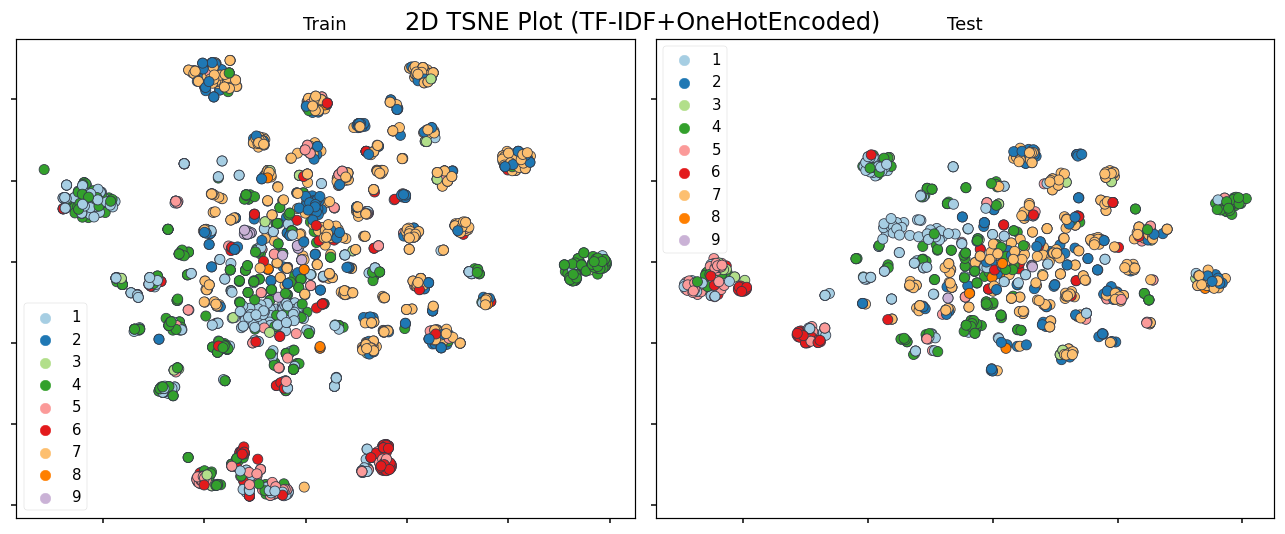

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=108, sharey=True)
fig.suptitle('2D TSNE Plot (TF-IDF+OneHotEncoded)', fontsize=16)

sns.scatterplot(ax=axes[0], x=train_tsne[:,0], y=train_tsne[:,1], 
                edgecolor='#353b48', hue=y_train, legend='full', 
                palette=palette, s=45)
axes[0].set_title("Train")
axes[0].set_yticklabels([])
axes[0].set_xticklabels([])
axes[0].grid(False)

sns.scatterplot(ax=axes[1], x=test_tsne[:,0], y=test_tsne[:,1], 
                edgecolor='#353b48',
                hue=y_test, legend='full', palette=palette, s=45)
axes[1].set_title("Test")
axes[1].set_yticklabels([])
axes[1].set_xticklabels([])
axes[1].grid(False)
plt.tight_layout()
plt.savefig('2D-TSNE-Plot.png', dpi=256)

# Machine learning model

In [36]:
# Helper code

def performance_evaluate(classifier, x_train, y_train, x_test, y_test, 
                          cm_suptitle='Confusion Matrix', cmap_color='Greys'):

  # Prediction
  y_train_pred = classifier.predict(x_train)
  y_test_pred = classifier.predict(x_test)

  print("-"*100)
  # Accuracy
  accuracy = (round(balanced_accuracy_score(y_train, y_train_pred), 4), 
              round(balanced_accuracy_score(y_test, y_test_pred), 4))
  print("Accuracy")
  print(f"\tTrain: {accuracy[0]}\tTest: {accuracy[1]}\n")

  print("-"*100)
  # F1 micro Score
  f1_micro = (round(f1_score(y_train, y_train_pred, average='micro'), 4), 
              round(f1_score(y_test, y_test_pred , average='micro'), 4))
  print("F1 micro Score")
  print(f"\tTrain: {f1_micro[0]}\tTest: {f1_micro[1]}\n")

  print("-"*100)
  # F1 macro Score
  f1_macro = (round(f1_score(y_train, y_train_pred, average='macro'),4), 
              round(f1_score(y_test, y_test_pred , average='macro'),4))
  print("F1 macro Score")
  print(f"\tTrain: {f1_macro[0]}\tTest: {f1_macro[1]}\n")

  print("-"*100)
  # Confusion Matrix
  fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=108, sharey=True)
  fig.suptitle(cm_suptitle, fontsize=18)

  cm1 = confusion_matrix(y_train, y_train_pred)
  sns.heatmap(cm1, annot=True,fmt="d",cmap=cmap_color, ax=axes[0])
  axes[0].set_title('Train')
  axes[0].set(xlabel="Predicted", ylabel = "Actual")

  cm2 = confusion_matrix(y_test, y_test_pred)
  sns.heatmap(cm2, annot=True,fmt="d",cmap=cmap_color, ax=axes[1])
  axes[1].set_title('Test')
  axes[1].set(xlabel="Predicted", ylabel = "Actual")  

  return accuracy, f1_micro, f1_macro

## Ensemble-Based

### Random Forest

In [37]:
rf_params={
    'bootstrap': [True],
    'max_depth': [5, 10, 20],
    'max_features': ['sqrt'],
    'min_samples_leaf': [4, 7],
    'n_estimators': [500, 1000, 1500]}

In [38]:
rf=RandomForestClassifier(n_jobs=-1)

gscv = GridSearchCV(rf, param_grid=rf_params, n_jobs=-1, verbose=2).\
                    fit(train, y_train)

gscv.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  9.1min finished


{'bootstrap': True,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'n_estimators': 1000}

----------------------------------------------------------------------------------------------------
Accuracy
	Train: 0.6253	Test: 0.448

----------------------------------------------------------------------------------------------------
F1 micro Score
	Train: 0.8302	Test: 0.6422

----------------------------------------------------------------------------------------------------
F1 macro Score
	Train: 0.6686	Test: 0.4833

----------------------------------------------------------------------------------------------------


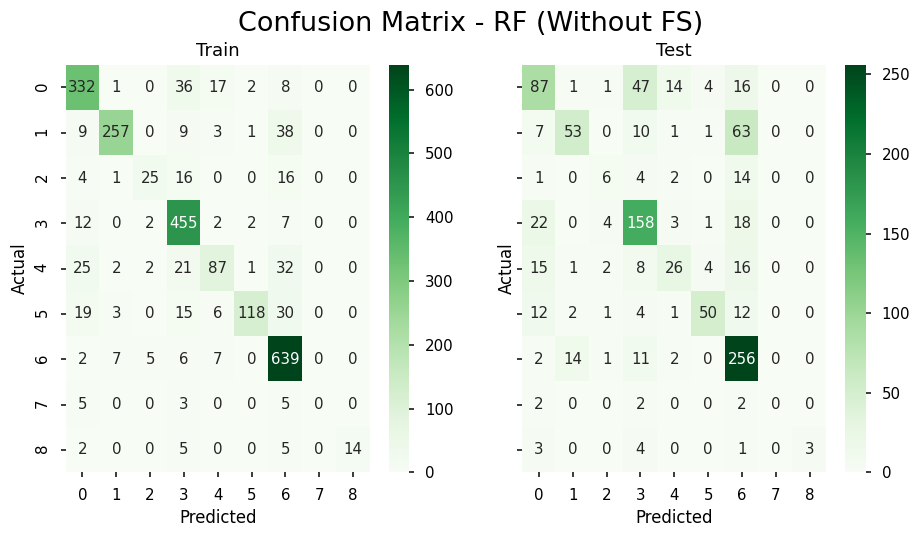

In [39]:
rf = RandomForestClassifier(bootstrap=gscv.best_params_['bootstrap'], 
                        max_depth=gscv.best_params_['max_depth'], 
                        max_features=gscv.best_params_['max_features'],
                        min_samples_leaf=gscv.best_params_['min_samples_leaf'],
                        n_estimators=gscv.best_params_['n_estimators'], n_jobs=-1).\
                        fit(train, y_train)

cm_suptitle='Confusion Matrix - RF (Without FS)'
cmap_color='Greens'

rf_acc, rf_micro, rf_macro = performance_evaluate(rf, train, y_train, 
                                                 test, y_test, 
                                                 cm_suptitle, cmap_color)

### Feature selection with RF

In [40]:
# Getting the indices for features with non zero values
imp_feat_idx = (np.nonzero(rf.feature_importances_))[0]

# Selecting non zero features from train and test
train_fs = (train[:, imp_feat_idx])
test_fs = (test[:, imp_feat_idx])

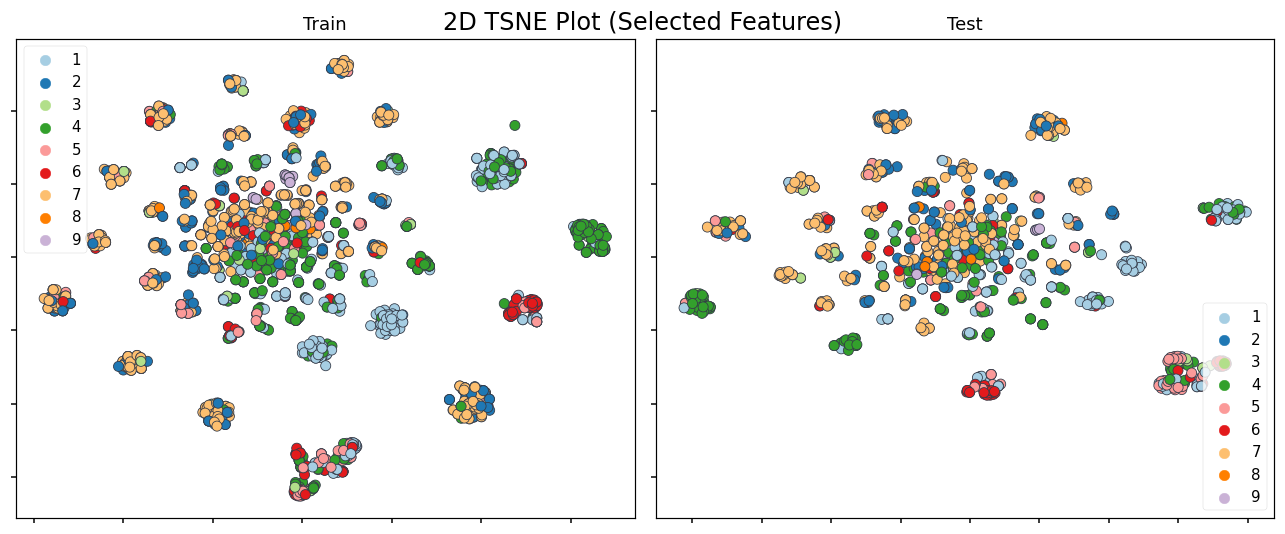

In [41]:
# Reducing dimension and projecting it onto 2D with t-SNE
train_tsne = TSNE(n_components=2, perplexity=50, n_jobs=-1).\
                  fit_transform(train_fs) 

# Reducing dimension and projecting it onto 2D with t-SNE
test_tsne = TSNE(n_components=2, perplexity=50, n_jobs=-1).\
                  fit_transform(test_fs) 

fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=108, sharey=True)
fig.suptitle('2D TSNE Plot (Selected Features)', fontsize=16)

sns.scatterplot(ax=axes[0], x=train_tsne[:,0], y=train_tsne[:,1], 
                edgecolor='#353b48', hue=y_train, legend='full', 
                palette=palette, s=45)
axes[0].set_title("Train")
axes[0].set_yticklabels([])
axes[0].set_xticklabels([])
axes[0].grid(False)

sns.scatterplot(ax=axes[1], x=test_tsne[:,0], y=test_tsne[:,1], 
                edgecolor='#353b48',
                hue=y_test, legend='full', palette=palette, s=45)
axes[1].set_title("Test")
axes[1].set_yticklabels([])
axes[1].set_xticklabels([])
axes[1].grid(False)
plt.tight_layout()
plt.savefig('2D-feature_importances_TSNE-Plot.png', dpi=256)

### Re-training RF with selected features

----------------------------------------------------------------------------------------------------
Accuracy
	Train: 0.6275	Test: 0.4516

----------------------------------------------------------------------------------------------------
F1 micro Score
	Train: 0.8333	Test: 0.6362

----------------------------------------------------------------------------------------------------
F1 macro Score
	Train: 0.6709	Test: 0.4885

----------------------------------------------------------------------------------------------------


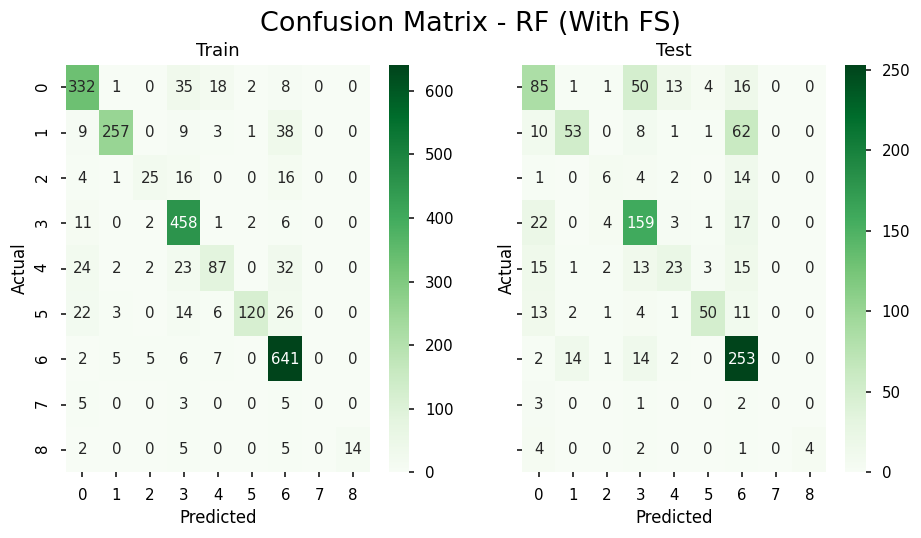

In [42]:
rf = RandomForestClassifier(bootstrap=gscv.best_params_['bootstrap'], 
                        max_depth=gscv.best_params_['max_depth'], 
                        max_features=gscv.best_params_['max_features'],
                        min_samples_leaf=gscv.best_params_['min_samples_leaf'],
                        n_estimators=gscv.best_params_['n_estimators'], n_jobs=-1).\
                        fit(train_fs, y_train)

cm_suptitle='Confusion Matrix - RF (With FS)'
cmap_color='Greens'

rf_acc_fs, rf_micro_fs, rf_macro_fs = performance_evaluate(rf, 
                                                           train_fs, y_train, 
                                                           test_fs, y_test,
                                                           cm_suptitle, 
                                                           cmap_color)

## Neighbourhood-Based

In [43]:
params = {
    'n_neighbors':[13, 21, 27],
    'algorithm':['kd_tree'],
    'weights':['distance']
    }

### k-NN

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   49.2s finished




Took 0:00:50.946241 time to find best parameters:
	{'algorithm': 'kd_tree', 'n_neighbors': 13, 'weights': 'distance'}


----------------------------------------------------------------------------------------------------
Accuracy
	Train: 1.0	Test: 0.4264

----------------------------------------------------------------------------------------------------
F1 micro Score
	Train: 1.0	Test: 0.594

----------------------------------------------------------------------------------------------------
F1 macro Score
	Train: 1.0	Test: 0.4539

----------------------------------------------------------------------------------------------------


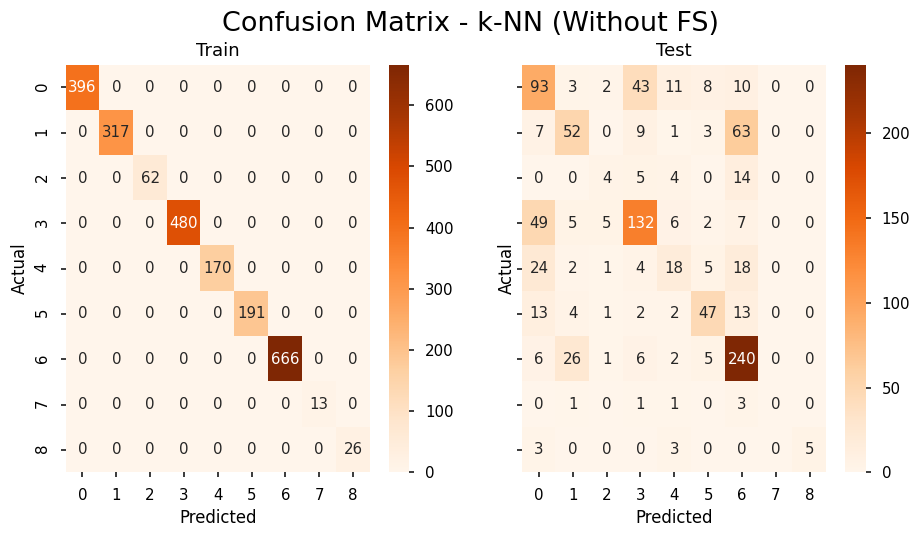

In [44]:
knn = KNeighborsClassifier(n_jobs=-1)

knn_cv_start = datetime.now()
knn_cv = GridSearchCV(knn, param_grid=params, cv=5, 
                      verbose=2, n_jobs=-1).fit(train, y_train) 
knn_cv_end= datetime.now()

best_knn=knn_cv.best_params_

print(f"\n\nTook {knn_cv_end-knn_cv_start} time to find best parameters:\n\t{best_knn}\n\n")

knn = KNeighborsClassifier(n_neighbors=best_knn['n_neighbors'],
                           weights=best_knn['weights'],
                           algorithm=best_knn['algorithm'],
                           n_jobs=-1).fit(train, y_train) 

cm_suptitle='Confusion Matrix - k-NN (Without FS)'
cmap_color='Oranges'

knn_acc, knn_micro, knn_macro = performance_evaluate(knn, 
                                                     train, y_train, 
                                                     test, y_test,
                                                     cm_suptitle, 
                                                     cmap_color)

### k-NN with selected features

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   27.5s finished


{'algorithm': 'kd_tree', 'n_neighbors': 27, 'weights': 'distance'}
----------------------------------------------------------------------------------------------------
Accuracy
	Train: 0.8695	Test: 0.4972

----------------------------------------------------------------------------------------------------
F1 micro Score
	Train: 0.9104	Test: 0.6412

----------------------------------------------------------------------------------------------------
F1 macro Score
	Train: 0.8858	Test: 0.5344

----------------------------------------------------------------------------------------------------


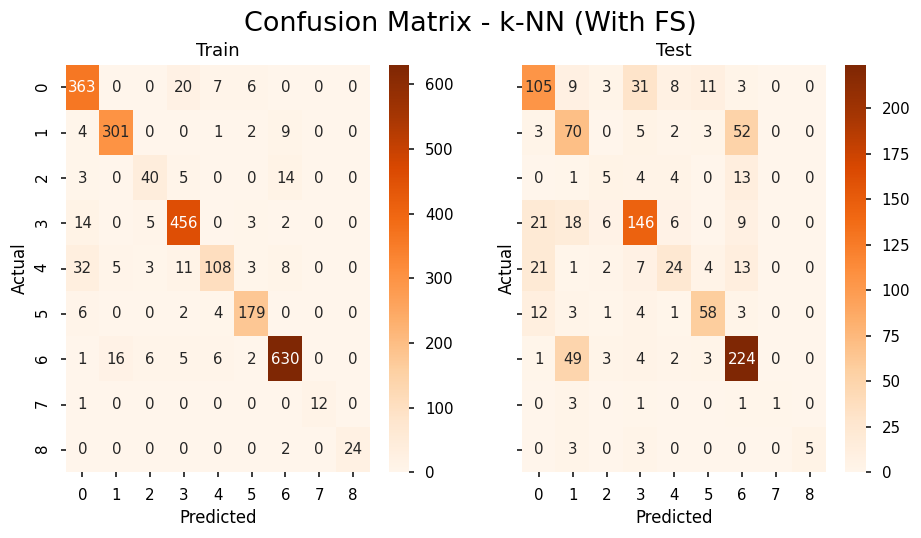

In [45]:
knn = KNeighborsClassifier(n_jobs=-1)

knn_cv = GridSearchCV(knn, param_grid=params, cv=5, 
                      verbose=2, n_jobs=-1).fit(train_fs, y_train) 

print(knn_cv.best_params_)

knn = KNeighborsClassifier(n_neighbors=best_knn['n_neighbors'],
                           weights=best_knn['weights'],
                           algorithm=best_knn['algorithm'],
                           n_jobs=-1)

knn.fit(train_fs, y_train) 

cm_suptitle='Confusion Matrix - k-NN (With FS)'
cmap_color='Oranges'

knn_acc_fs, knn_micro_fs, knn_macro_fs = performance_evaluate(knn, 
                                                           train_fs, y_train, 
                                                           test_fs, y_test,
                                                           cm_suptitle, 
                                                           cmap_color)

## Linear Models

### SVM

In [46]:
params = {'loss': ['hinge'], 
          'penalty': ['l1', 'l2', 'elasticnet'],
          'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
          'class_weight': ['balanced'],
          'max_iter':[250, 500]}          

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  7.0min finished


{'alpha': 0.0001, 'class_weight': 'balanced', 'loss': 'hinge', 'max_iter': 500, 'penalty': 'l2'} 

---------------------------------------------------------------------------------------------------- 

----------------------------------------------------------------------------------------------------
Accuracy
	Train: 0.9984	Test: 0.531

----------------------------------------------------------------------------------------------------
F1 micro Score
	Train: 0.9978	Test: 0.6603

----------------------------------------------------------------------------------------------------
F1 macro Score
	Train: 0.9843	Test: 0.5608

----------------------------------------------------------------------------------------------------


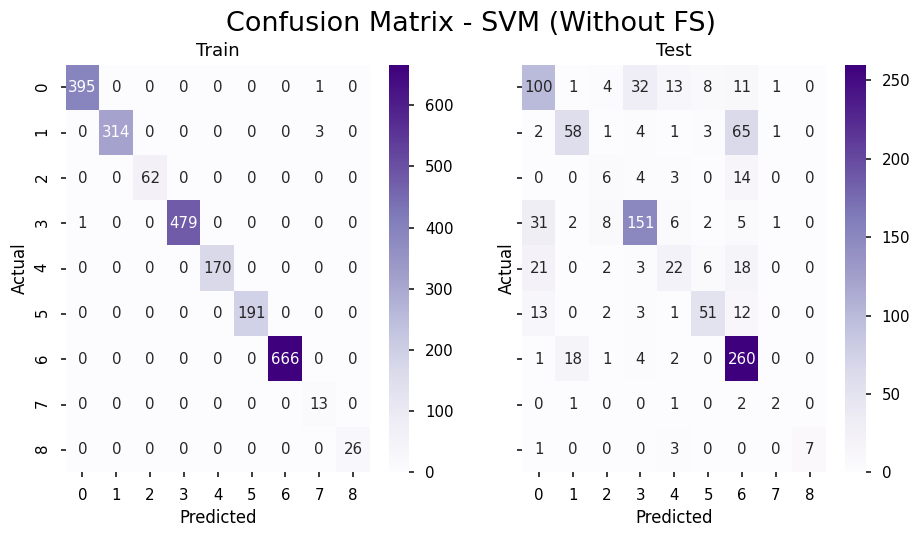

In [47]:
sgd_svm = SGDClassifier(n_jobs=-1, early_stopping=False)

gsv = GridSearchCV(sgd_svm, param_grid=params, n_jobs=-1, cv=5, verbose=2)

gsv.fit(train, y_train)

print(gsv.best_params_, "\n")
print("-"*100, "\n")

sgd_svm = SGDClassifier(alpha=gsv.best_params_['alpha'], 
                        loss=gsv.best_params_['loss'], 
                        penalty=gsv.best_params_['penalty'],
                        max_iter=gsv.best_params_['max_iter'],
                        class_weight=gsv.best_params_['class_weight'],
                        n_jobs=-1, early_stopping=False).\
                        fit(train, y_train)

cm_suptitle='Confusion Matrix - SVM (Without FS)'
cmap_color='Purples'

svm_acc, svm_micro, svm_macro = performance_evaluate(sgd_svm, 
                                                     train, y_train,
                                                     test, y_test,
                                                     cm_suptitle, 
                                                     cmap_color)

### SVM with selected features

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  4.9min finished


{'alpha': 0.0001, 'class_weight': 'balanced', 'loss': 'hinge', 'max_iter': 500, 'penalty': 'elasticnet'} 

---------------------------------------------------------------------------------------------------- 

----------------------------------------------------------------------------------------------------
Accuracy
	Train: 0.8543	Test: 0.5981

----------------------------------------------------------------------------------------------------
F1 micro Score
	Train: 0.8195	Test: 0.6392

----------------------------------------------------------------------------------------------------
F1 macro Score
	Train: 0.7818	Test: 0.5615

----------------------------------------------------------------------------------------------------


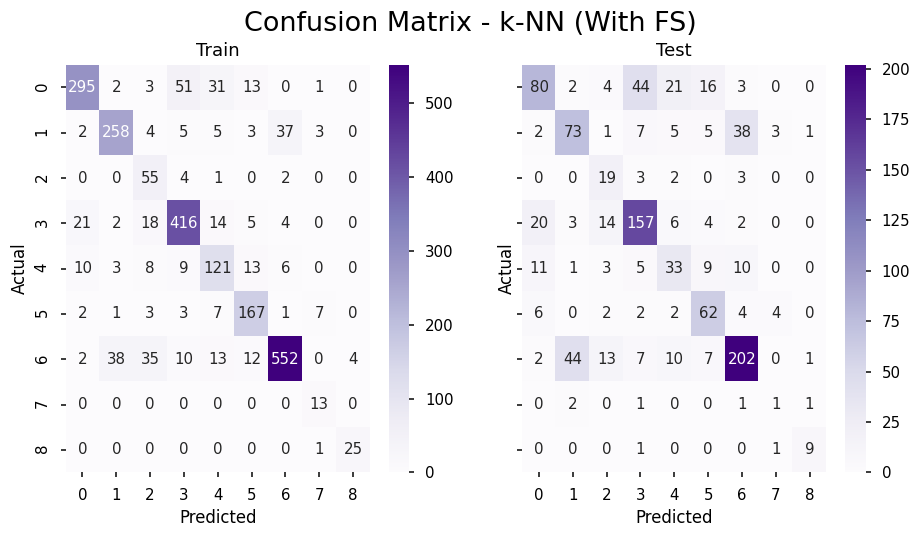

In [48]:
sgd_svm = SGDClassifier(n_jobs=-1, early_stopping=False)

gsv = GridSearchCV(sgd_svm, param_grid=params, n_jobs=-1, cv=5, verbose=2)

gsv.fit(train_fs, y_train)

print(gsv.best_params_, "\n")
print("-"*100, "\n")

sgd_svm = SGDClassifier(alpha=gsv.best_params_['alpha'], 
                        loss=gsv.best_params_['loss'], 
                        penalty=gsv.best_params_['penalty'],
                        max_iter=gsv.best_params_['max_iter'],
                        class_weight=gsv.best_params_['class_weight'],
                        n_jobs=-1, early_stopping=False).\
                        fit(train_fs, y_train)

cm_suptitle='Confusion Matrix - k-NN (With FS)'
cmap_color='Purples'

svm_acc_fs, svm_micro_fs, svm_macro_fs = performance_evaluate(sgd_svm, 
                                                              train_fs, y_train,
                                                              test_fs, y_test,
                                                              cm_suptitle, 
                                                              cmap_color)

### Logistic Regression

In [49]:
params = {'loss': ['log'], 
          'penalty': ['l1', 'l2', 'elasticnet'],
          'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
          'class_weight': ['balanced'],
          'max_iter':[250, 500]} 

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  8.2min finished


{'alpha': 0.0001, 'class_weight': 'balanced', 'loss': 'log', 'max_iter': 500, 'penalty': 'elasticnet'} 

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Accuracy
	Train: 0.9932	Test: 0.5207

----------------------------------------------------------------------------------------------------
F1 micro Score
	Train: 0.9884	Test: 0.6482

----------------------------------------------------------------------------------------------------
F1 macro Score
	Train: 0.9931	Test: 0.5497

----------------------------------------------------------------------------------------------------


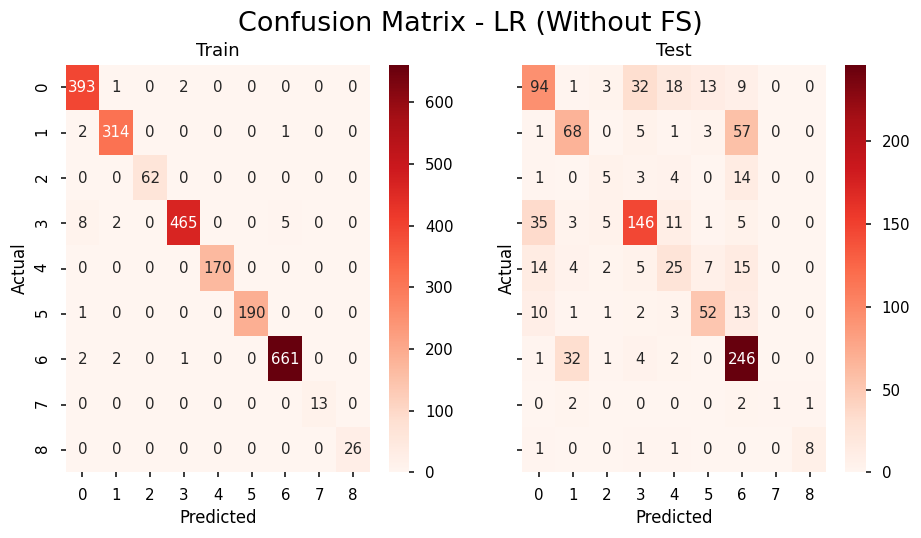

In [50]:
sgd_log = SGDClassifier(n_jobs=-1, early_stopping=False)

gsv = GridSearchCV(sgd_log, param_grid=params, n_jobs=-1, cv=5, verbose=2)

gsv.fit(train, y_train)

print(gsv.best_params_, "\n")
print("-"*100)

sgd_log = SGDClassifier(alpha=gsv.best_params_['alpha'], 
                        loss=gsv.best_params_['loss'], 
                        penalty=gsv.best_params_['penalty'],
                        max_iter=gsv.best_params_['max_iter'],
                        class_weight=gsv.best_params_['class_weight'],
                        n_jobs=-1, early_stopping=False).\
                        fit(train, y_train)

cm_suptitle='Confusion Matrix - LR (Without FS)'
cmap_color='Reds'

log_acc, log_micro, log_macro = performance_evaluate(sgd_log, 
                                                     train, y_train,
                                                     test, y_test,
                                                     cm_suptitle, 
                                                     cmap_color)

### Logistic Regression with selected features

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  5.9min finished


{'alpha': 0.0001, 'class_weight': 'balanced', 'loss': 'log', 'max_iter': 250, 'penalty': 'elasticnet'} 

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Accuracy
	Train: 0.8192	Test: 0.5938

----------------------------------------------------------------------------------------------------
F1 micro Score
	Train: 0.7785	Test: 0.6291

----------------------------------------------------------------------------------------------------
F1 macro Score
	Train: 0.7688	Test: 0.5647

----------------------------------------------------------------------------------------------------


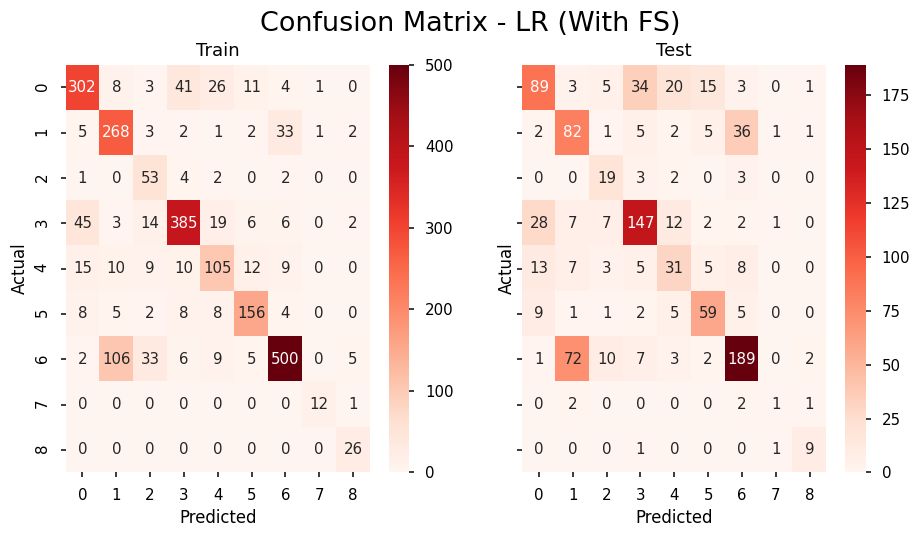

In [51]:
sgd_log = SGDClassifier(n_jobs=-1, early_stopping=False)

gsv = GridSearchCV(sgd_log, param_grid=params, n_jobs=-1, cv=5, verbose=2)

gsv.fit(train_fs, y_train)

print(gsv.best_params_, "\n")
print("-"*100)

sgd_log = SGDClassifier(alpha=gsv.best_params_['alpha'], 
                        loss=gsv.best_params_['loss'], 
                        penalty=gsv.best_params_['penalty'],
                        max_iter=gsv.best_params_['max_iter'],
                        class_weight=gsv.best_params_['class_weight'],
                        n_jobs=-1, early_stopping=False).\
                        fit(train_fs, y_train)

cm_suptitle='Confusion Matrix - LR (With FS)'
cmap_color='Reds'

log_acc_fs, log_micro_fs, log_macro_fs = performance_evaluate(sgd_log, 
                                                              train_fs, y_train,
                                                              test_fs, y_test,
                                                              cm_suptitle, 
                                                              cmap_color)

<a name="cell-id8"></a>
# Conclusion

In [52]:
# Removing files
! rm /content/training_variants
! rm /content/training_text
! rm -I *.zip

In [53]:
end=datetime.now()

print(f"Time took to run whole Notebook - {end-start} (mins).")

Time took to run whole Notebook - 0:46:28.807205 (mins).


In [54]:
summary = {
    'Model' : ['Random Forest', 'k-NN', 'SVM-SGD', 'LR-SGD'],
           
    'F1 Micro Score (train, text)': [rf_micro, knn_micro, svm_micro, log_micro],

    'F1 Micro Score FS  (train, text)': [rf_micro_fs, knn_micro_fs, svm_micro_fs, log_micro_fs],

    'F1 Macro Score (train, text)': [rf_macro, knn_macro, svm_macro, log_macro],

    'F1 Macro Score FS (train, text)': [rf_macro_fs, knn_macro_fs, svm_macro_fs, log_macro_fs],

    'Accuracy (train, text)': [rf_acc, knn_acc, svm_acc, log_acc],

    'Accuracy FS (train, text)': [rf_acc_fs, knn_acc_fs, svm_acc_fs, log_acc_fs]
}

In [55]:
summary = pd.DataFrame(summary)

In [56]:
summary

,Model,"F1 Micro Score (train, text)","F1 Micro Score FS (train, text)","F1 Macro Score (train, text)","F1 Macro Score FS (train, text)","Accuracy (train, text)","Accuracy FS (train, text)"
0,Random Forest,"(0.8302, 0.6422)","(0.8333, 0.6362)","(0.6686, 0.4833)","(0.6709, 0.4885)","(0.6253, 0.448)","(0.6275, 0.4516)"
1,k-NN,"(1.0, 0.594)","(0.9104, 0.6412)","(1.0, 0.4539)","(0.8858, 0.5344)","(1.0, 0.4264)","(0.8695, 0.4972)"
2,SVM-SGD,"(0.9978, 0.6603)","(0.8195, 0.6392)","(0.9843, 0.5608)","(0.7818, 0.5615)","(0.9984, 0.531)","(0.8543, 0.5981)"
3,LR-SGD,"(0.9884, 0.6482)","(0.7785, 0.6291)","(0.9931, 0.5497)","(0.7688, 0.5647)","(0.9932, 0.5207)","(0.8192, 0.5938)"
